## Verify Ground Truth ##

Given cut-out regions from brightfield images, paired with MPM images, verify the location of the MPM region within the brightfield image. Ground Truth coordinates taken from the annotated brightfield images are read from a csv file and mapped to the location within the cut-out regions by subtracting the location of the cut-out (from another csv).

In [58]:
import numpy as np
import matplotlib.pyplot as plt #requires Pillow to read tiffs
from skimage.color import rgb2gray
from PIL import Image
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score
from scipy import ndimage

In [59]:
brightfield_folder = '../data/new_rois/'
brightfield_filename = '%d_%d.tif' #substitute slide number and region id

mpm_folder = '../data/processed/'
mpm_filename = '%d_%d_gs.tif' #substitute slide number and region id

cutout_metadatafile = brightfield_folder + 'roi_locations.csv'
gt_metadatafile = './gt_roi_locations.csv'

In [60]:
cutout_locations = np.genfromtxt(cutout_metadatafile, delimiter=',', dtype=None, encoding="utf8")
cutout_locations = cutout_locations.astype(int) #Convert to integers

gt_positions = np.genfromtxt(gt_metadatafile, delimiter=',', dtype=None, encoding="utf8")
gt_positions = gt_positions[1:].astype(int) #Drop header row, convert to integers

proposed_gt_positions = []

In [61]:
gt_positions

array([[148184,      1,   3342,   1979,   3584,   2217,    243,    239],
       [148184,      2,   3626,   2060,   3817,   2276,    192,    217],
       [148184,      3,   3839,   2284,   4030,   2477,    192,    194],
       [148184,      4,   3844,   1866,   4068,   2094,    225,    229],
       [148184,      5,   3973,   1740,   4200,   1900,    228,    161],
       [148184,      6,   4235,   1569,   4449,   1756,    215,    188],
       [148184,      7,   2837,    581,   3013,    763,    177,    183],
       [148185,      1,   1046,   1389,   1257,   1562,    212,    174],
       [148185,      2,   1837,   1107,   2045,   1281,    209,    175],
       [148185,      3,   2346,    966,   2557,   1150,    212,    185],
       [148185,      4,   2691,    887,   2889,   1087,    199,    201],
       [148185,      5,   2625,   1160,   2814,   1333,    190,    174],
       [148185,      6,   2942,   1094,   3122,   1271,    181,    178],
       [148185,      7,   3164,    892,   3404,   1

In [62]:
cutout_locations

array([[148184,      1,   3133,   1774,   3881,   2497],
       [148184,      2,   3465,   1943,   4045,   2431],
       [148184,      3,   3654,   2170,   4169,   2737],
       [148184,      4,   3694,   1603,   4363,   2332],
       [148184,      5,   3693,   1634,   4496,   2102],
       [148184,      6,   4083,   1468,   4597,   1955],
       [148184,      7,   2673,    358,   3208,    868],
       [148185,      1,    778,   1208,   1394,   1831],
       [148185,      2,   1718,    813,   2279,   1414],
       [148185,      3,   2238,    805,   2753,   1377],
       [148185,      4,   2497,    781,   3080,   1241],
       [148185,      5,   2404,    971,   3076,   1482],
       [148185,      6,   2723,    885,   3415,   1551],
       [148185,      7,   3060,    692,   3687,   1230],
       [148185,      8,   3166,     16,   3580,    717],
       [148185,      9,   3480,    569,   4143,   1149],
       [148185,     10,   3598,    244,   4253,    911],
       [148185,     11,   3746,

In [108]:
'''
No longer in use. Use plot_with_outline instead, this allows rotations
Draw 5 pixel outline of region of interest on an image. Region of interest starts (top left) at pos and has size size
Image format is np.array so coordinates are [y,x]. pos and size of region are given as (x,y) tuples
'''
def draw_outline(image, pos, size):
#     print('drawing outline from pos %r, %r with size %r, %r on image size %r, %r'%(*pos, *size, *image.shape))
    newimage = image.copy()
    if np.max(image) > 1:
        val = 255
    else:
        val = 1.0
    
    top, bottom, left, right = (max(0, pos[0]-6), \
                                min(image.shape[1], pos[0]+size[0]+6), \
                                max(0, pos[1]-6), \
                                min(image.shape[0], pos[1]+size[1]+6))
    
#     print('coords for box: %r, %r, %r, %r'%(top, bottom, left, right))
    newimage[left:(right+1),top:pos[0]] = val
    newimage[left:(right+1),(pos[0]+size[0]+1):(bottom+1)] = val
    newimage[left:pos[1],top:(bottom+1)] = val
    newimage[(pos[1]+size[1]+1):(right+1),top:(bottom+1)] = val
    
    return newimage

In [104]:
'''
Plot image with an area outlined on it. Region of interest is a rectangle with upper left corner given by
pos1, at a rotation of rot degrees, and size given in pixels
pos1 and size are given as (x,y) tuples
'''
def plot_with_outline(image, pos1, rot, size, cmap='gray'):
    if np.max(image) > 1:
        val = 255
    else:
        val = 1.0

    rot = rot * np.pi / 180
    pos2 = [pos1[0] + size[0]*np.cos(-rot), pos1[1] - size[0]*np.sin(rot)]
    pos3 = [pos1[0] + size[1]*np.sin(rot), pos1[1] + size[1]*np.cos(rot)]
    pos4 = np.array(pos2)+np.array(pos3)-np.array(pos1)
#     print('Corners at %r, %r, %r, %r'%(pos1, pos2, pos3, pos4))
    plt.imshow(image, cmap=cmap)
    plt.plot(*list(zip(pos1, pos2)), 'w-', lw=3)
    plt.plot(*list(zip(pos1, pos3)), 'w-', lw=3)
    plt.plot(*list(zip(pos2, pos4)), 'w-', lw=3)
    plt.plot(*list(zip(pos3, pos4)), 'w-', lw=3)
#     plt.show()


In [105]:
'''
Calculate the (adjusted) mutual information between two images ref and flo, 
where the centre of flo corresponds to pixel position centre=(y,x) of ref.
and where pixels of flo are masked by mask. Masked pixels are ignored.

mask must be the same size as flo.

If (unmasked part of) flo is not wholly contained within ref, ref is clipped, or
extended with zeros if clip = False.
'''
def masked_MI(ref, flo, mask, centre, adj_mi=True, clip=True):
    zone_dims = flo.shape
    ref_size = ref.shape
    if clip:
        #using integer division; in fact should interpolate if flo_im has even # pixels
        refcoords = (max(centre[0]-zone_dims[0]//2,0), min(centre[0]+(zone_dims[0]+1)//2, ref_size[0]), \
                     max(centre[1]-zone_dims[1]//2,0), min(centre[1]+(zone_dims[1]+1)//2, ref_size[1]))
#         print(refcoords)
        flocoords = (-min(centre[0]-zone_dims[0]//2,0), zone_dims[0]+min(ref_size[0]-(centre[0]+(zone_dims[0]+1)//2),0), \
                     -min(centre[1]-zone_dims[1]//2,0), zone_dims[1]+min(ref_size[1]-(centre[1]+(zone_dims[1]+1)//2),0))
#         print(flocoords)
    else:
        #pad ref with zeros.
        raise NotImplemented

    ref_zone = ref[refcoords[0]:refcoords[1], refcoords[2]:refcoords[3]]
    flo_zone = flo[flocoords[0]:flocoords[1], flocoords[2]:flocoords[3]]
    mask_zone = mask[flocoords[0]:flocoords[1], flocoords[2]:flocoords[3]]
#     print("calculating mutual info for flo image size %r vs ref image zone size %r,"%(zone_dims, ref_zone.shape),\
#           "both masked to %d locations"%len(flo_zone[mask_zone>0]))
    if adj_mi:
        mi = adjusted_mutual_info_score(ref_zone[mask_zone>0],flo_zone[mask_zone>0])
    else:
        mi = mutual_info_score(ref_zone[mask_zone>0],flo_zone[mask_zone>0])
#     print('mi=%.4f'%mi)
    return mi

Grid search function based around location of ggt

In [122]:
'''
Images are passed in as np arrays, indexing as [y,x]. inital translation and scaling are given as (x,y) pixels and
(x,y) proportions respectively, and refer to the adjustment made to flo to register with ref. init_transl is the 
coordinates of the top left corner of the GGT within the cutout region.
Since flo has size 512 px and ref is usually around 250 the initial scale should be around 0.5 
Since cut-out is padded by 25-50 px in each dir compared to GT, initial translation should lie between +25 and +50
'''
def gridSearchMIRegister(ref, flo, init_transl, init_scaling):
    ctr=0
    
#     plt.imshow(ref, cmap='gray', vmin=0, vmax=255)
#     plt.title("Reference image")
#     plt.show()
#     plt.imshow(flo, cmap='gray', vmin=0, vmax=255)
#     plt.title("Floating image")
#     plt.show()

#     scaling = 1.0/2.5 #fixed on basis of image resolutions (may need to adjust what it is fixed to but we should be able to know this)
    flo2 = Image.fromarray(flo, mode='L') #Make a copy rather than affecting the passed in data, also convert to an Image for resize function
    
    #Calculate baseline MI at the given initial scaling and translation
    #Find the size of the GGT region as (x,y)
    ggtsize = np.rint((init_scaling[0] * len(flo[0]), init_scaling[1] * len(flo))).astype(int)
    print('At given ground truth (scaling %.3f, %.3f; centre %d, %d, size %d, %d):'%(*init_scaling, *(init_transl+ggtsize//2), *ggtsize))
    rescaled_flo = flo2.resize(ggtsize)
    rescaled_flo = np.asarray(rescaled_flo)
    ref_range = (init_transl[1], init_transl[0], ref.shape[0]-init_transl[1], ref.shape[1]-init_transl[0])
    flo_range = (0, 0, rescaled_flo.shape[0], rescaled_flo.shape[1])
    overlap = (min(ref_range[2], flo_range[2]), min(ref_range[3], flo_range[3]))
    gt_ref = ref[ref_range[0]:(overlap[0]+ref_range[0]), ref_range[1]:(overlap[1]+ref_range[1])]
    gt_flo = rescaled_flo[flo_range[0]:(overlap[0]+flo_range[0]), flo_range[1]:(overlap[1]+flo_range[1])]
    max_mi = mutual_info_score(gt_ref.flatten(), \
                           gt_flo.flatten())
    mi_max_at = (np.mean(init_scaling), 0, init_transl[0]+ggtsize[0]//2, init_transl[1]+ggtsize[1]//2)
#     max_ami = adjusted_mutual_info_score(gt_ref.flatten(), \
#                            gt_flo.flatten())

#     print('MI = %.4f, AMI = %.4f'%(max_mi, max_ami))
    print('GGT: MI = %.4f'%(max_mi,))
    mi_scores=[max_mi,]
#     ami_scores=[max_ami,]

    plt.figure(figsize=(12,8))
    plt.subplot(131)
#     plt.imshow(draw_outline(ref, init_transl, ggtsize), cmap='gray')
    plot_with_outline(ref, init_transl, 0, ggtsize)
    plt.subplot(132)
    plt.imshow(flo, cmap='gray')
    plt.subplot(133)
    combined_image = np.zeros((*overlap,3))
    combined_image[...,0] = normalize(gt_ref)
    combined_image[...,2] = normalize(gt_flo)
    plt.imshow(combined_image)
    plt.show()

#     max_scaling = init_scaling * 1.1
#     min_scaling = init_scaling * 0.9
    
    #Set up search grid
    #Takes approx 1 min per image pair per 600 grid positions (depending on size of region)
    #A lot quicker if only MI not AMI as well
    if False: #reduced grid for testing
        max_transl = init_transl + [30,30] + ggtsize//2
        min_transl = init_transl + [-30,-30] + ggtsize//2
        rot_bounds = [-7.5, 7.5]
        rot_steps = 13
        transl_step = 5
#         scaling_steps = 20
    else: #bigger grid for full run (still not big enough?)
        max_transl = init_transl + [80,80] + ggtsize//2
        min_transl = init_transl + [-80,-80] + ggtsize//2
        rot_bounds = [-15, 15]
        rot_steps = 31
        transl_step = 2
#         scaling_steps = 41
    

    #Test whole-pixel translations within the bounds given, separated by step size transl_step
    xtrans = np.arange(min_transl[0], max_transl[0]+1, transl_step)
    ytrans = np.arange(min_transl[1], max_transl[1]+1, transl_step)

    #Use a grid of evenly-spaced rescalings between the lowest x or y scaling and the highest.
#     xscaling = np.linspace(min(min_scaling), max(max_scaling), scaling_steps)
    x = 0.4 #Test fixed scaling with grid of rotations
    
    rot = np.linspace(*rot_bounds, rot_steps)
    
    pts = len(rot)*len(xtrans)*len(ytrans)
    print("Finding maximum MI on a grid of (%d x %d x %d) = %d points"%\
          (len(rot), len(xtrans), len(ytrans), \
           pts))

    #calculate new size as newsize = (xsize,ysize)
    newsize = np.rint((x * len(flo[0]), x * len(flo))).astype(int)
    start_im = flo2.resize(newsize)
    
    rescaled_flo = np.asarray(start_im)

#     offset = np.rint((ggtsize-newsize)/2).astype(int)
#     print("Offset for scale %.3f (size %d, %d) is %d %d"%(x, *newsize, *offset))
    offset = [0,0] #xtrans has now been re-based to refer to the location of the image centre

    for r in rot:
#         rescaled_flo = start_im.copy()
        mask = np.ones(rescaled_flo.shape).astype('uint8')
        flo_rot = ndimage.rotate(rescaled_flo, r, reshape=True, order=2, mode='constant')
        mask_rot = ndimage.rotate(mask, r, reshape=True, order=2, mode='constant')
#         rescaled_flo = rescaled_flo.rotate(r)
#         rescaled_flo = np.asarray(rescaled_flo)

        for xt in (xtrans+offset[0]):
            for yt in (ytrans+offset[1]):

                mi = masked_MI(ref, flo_rot, mask_rot, (yt, xt), adj_mi=False, clip=True)
#                 if xt > 0 and yt > 0:
#                     ref_range = (yt, xt, ref.shape[0]-yt, ref.shape[1]-xt)
#                     flo_range = (0, 0, rescaled_flo.shape[0], rescaled_flo.shape[1])

#                 elif yt > 0:
#                     ref_range = (yt, 0, ref.shape[0]-yt, ref.shape[1])
#                     flo_range = (0, -xt, rescaled_flo.shape[0], rescaled_flo.shape[1]+xt)

#                 elif xt > 0:
#                     ref_range = (0, xt, ref.shape[0], ref.shape[1]-xt)
#                     flo_range = (-yt, 0, rescaled_flo.shape[0]+yt, rescaled_flo.shape[1])

#                 else:
#                     ref_range = (0, 0, ref.shape[0], ref.shape[1])
#                     flo_range = (-yt, -xt, rescaled_flo.shape[0]+yt, rescaled_flo.shape[1]+xt)

#                 overlap = (min(ref_range[2], flo_range[2]), min(ref_range[3], flo_range[3]))

#                 mi = mutual_info_score(ref[ref_range[0]:(overlap[0]+ref_range[0]), ref_range[1]:(overlap[1]+ref_range[1])].flatten(), \
#                                        rescaled_flo[flo_range[0]:(overlap[0]+flo_range[0]), flo_range[1]:(overlap[1]+flo_range[1])].flatten())
#                 ami = adjusted_mutual_info_score(ref[ref_range[0]:(overlap[0]+ref_range[0]), ref_range[1]:(overlap[1]+ref_range[1])].flatten(), \
#                                        rescaled_flo[flo_range[0]:(overlap[0]+flo_range[0]), flo_range[1]:(overlap[1]+flo_range[1])].flatten())

                #                     print("MI score is: %.4f"%mi)
                if mi > max_mi:
#                 if mi > max_mi or ami > max_ami:
                    if mi > max_mi:
                        max_mi = mi
                        mi_max_at = (x, r, xt, yt)
#                     if ami > max_ami:
#                         max_ami = ami
#                         ami_max_at = (x, xt, yt)
#                     print("New max found at translation (%.3f, %.3f)"%(xt, yt), "and scale %.3f"%x)
#                     print('Ranges:', ref_range, flo_range)
#                     print('Overlap pixels:',overlap)
#                     print('MI: %.4f \tAMI: %.4f'%(mi, ami))
#                     plt.imshow(ref[ref_range[0]:(overlap[0]+ref_range[0]), ref_range[1]:(overlap[1]+ref_range[1])], cmap='gray', vmin=0, vmax=255)
#                     plt.show()
#                     plt.imshow(rescaled_flo[flo_range[0]:(overlap[0]+flo_range[0]), flo_range[1]:(overlap[1]+flo_range[1])], cmap='gray', vmin=0, vmax=255)
#                     plt.show()
                mi_scores.append(mi)
#                 ami_scores.append(ami)

                ctr += 1
                if not ctr%5000:
                    print('At grid point %d (%2.1f%%): scale %.3f, centre (%d, %d), rotation %.2f. Max MI=%.4f'%(ctr, 100*ctr/pts, x, xt, yt, r, max_mi))
#                     print('At grid point %d (%2.1f%%): scale %.3f, translation (%d, %d). Max MI=%.4f, Max AMI=%.4f'%(ctr, 100*ctr/pts, x, xt, yt, max_mi, max_ami))
        
        
    #Show the resulting transform (overlap region)
    (x, r, xt, yt) = mi_max_at
#     bestsize = np.rint((x * len(flo[0]), x * len(flo))).astype(int)
#     rescaled_flo = flo2.resize(bestsize)
#     rescaled_flo = np.asarray(rescaled_flo)

    rescaled_flo = ndimage.rotate(rescaled_flo, r, reshape=True, order=2, mode='constant')
#     rescaled_flo = start_im.copy()
#     rescaled_flo = rescaled_flo.rotate(r)
#     rescaled_flo = np.asarray(rescaled_flo)
#     if xt > 0 and yt > 0:
#         ref_range = (yt, xt, ref.shape[0]-yt, ref.shape[1]-xt)
#         flo_range = (0, 0, rescaled_flo.shape[0], rescaled_flo.shape[1])

#     elif yt > 0:
#         ref_range = (yt, 0, ref.shape[0]-yt, ref.shape[1])
#         flo_range = (0, -xt, rescaled_flo.shape[0], rescaled_flo.shape[1]+xt)

#     elif xt > 0:
#         ref_range = (0, xt, ref.shape[0], ref.shape[1]-xt)
#         flo_range = (-yt, 0, rescaled_flo.shape[0]+yt, rescaled_flo.shape[1])

#     else:
#         ref_range = (0, 0, ref.shape[0], ref.shape[1])
#         flo_range = (-yt, -xt, rescaled_flo.shape[0]+yt, rescaled_flo.shape[1]+xt)

#     overlap = (min(ref_range[2], flo_range[2]), min(ref_range[3], flo_range[3]))

    print('At revised ground truth: scaling %.3f; rotation %.2f; centre (%d, %d); size (%d, %d):'%(x, r, xt, yt, *newsize))
    print('MI = %.4f'%(max_mi,))
#     print('MI = %.4f, AMI = %.4f'%(max_mi, max_ami))
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plot_with_outline(ref, (xt-newsize[0]//2, yt-newsize[1]//2), r, newsize)
#     ref_final = draw_outline(ref, (xt-newsize[0]//2, yt-newsize[1]//2), (newsize[0], newsize[1]))
#     plt.imshow(ref_final, cmap='gray')
    plt.subplot(132)
#     flo_final = rescaled_flo[flo_range[0]:(overlap[0]+flo_range[0]), flo_range[1]:(overlap[1]+flo_range[1])]
    flo_final = rescaled_flo
    plt.imshow(flo_final, cmap='gray')
    plt.subplot(133)
    combined_image = np.zeros((*flo_final.shape,3))
    flo_final = normalize(flo_final)
    ref_final = ref[(yt-flo_final.shape[0]//2):(yt+(flo_final.shape[0]+1)//2), \
                    (xt-flo_final.shape[1]//2):(xt+(flo_final.shape[1]+1)//2)]
    ref_final = normalize(ref_final)
    combined_image[...,0] = ref_final
    combined_image[...,2] = flo_final
    plt.imshow(combined_image)
    plt.show()

    return mi_scores, mi_max_at
#     return mi_scores, mi_max_at, ami_scores, ami_max_at

In [123]:
#adjust image intensities such that all values lie between 0 and 1
def normalize(image):
    imin = np.min(image)
    imax = np.max(image)
    return (image - imin)/(imax-imin)

For each region in roi_locations, open the corresponding brightfield and MPM images and register using grid search.

Registering images for region 1 on slide 148184 (region 1 of 27)
At given ground truth (scaling 0.475, 0.467; centre 330, 324, size 243, 239):
GGT: MI = 0.0476


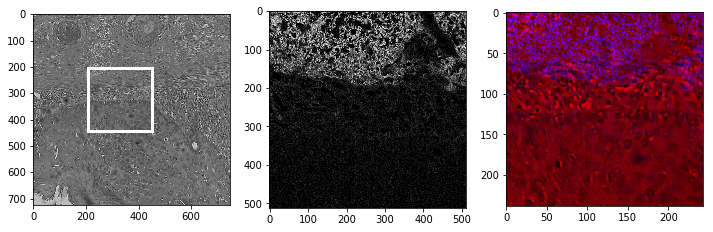

Finding maximum MI on a grid of (31 x 81 x 81) = 203391 points
At grid point 5000 (2.5%): scale 0.400, centre (372, 360), rotation -15.00. Max MI=0.0793
At grid point 10000 (4.9%): scale 0.400, centre (334, 316), rotation -14.00. Max MI=0.0826
At grid point 15000 (7.4%): scale 0.400, centre (296, 272), rotation -13.00. Max MI=0.0826
At grid point 20000 (9.8%): scale 0.400, centre (256, 390), rotation -12.00. Max MI=0.0826


KeyboardInterrupt: 

In [124]:
%%time

flo_size = 512
for idx, region in enumerate(cutout_locations):
    slide_id = region[0]
    region_id = region[1]
    region_coords = (region[2:4], region[4:])
    print("Registering images for region %d on slide %d (region %d of %d)"%(region_id, slide_id, idx+1, len(cutout_locations)))
    try:
        ref_im = plt.imread(brightfield_folder+brightfield_filename%(slide_id,region_id))
    except:
        print("Brightfield image not found for region %d of slide %d"%(region_id, slide_id))
        continue
    ref_im = np.rint(rgb2gray(ref_im)*255.).astype('uint8')
    
    try:
        flo_im = plt.imread(mpm_folder+mpm_filename%(slide_id,region_id))
    except:
        print("MPM image not found for region %d of slide %d"%(region_id, slide_id))
        continue

    flo_im = np.rint(rgb2gray(flo_im)*255.).astype('uint8')

    ggt_trans = gt_positions[idx][2:4]-region[2:4]
    ggt_scale = gt_positions[idx][6:]/flo_size #all MPM images are the same size
    
    #Do the grid search
    mi_scores, mi_max_at = gridSearchMIRegister(ref_im, flo_im, ggt_trans, ggt_scale)
    
    #mi_max_at contains (scale, rot, x_centre, y_centre)
    #Overall position within mosaic is the region coords plus the translation to the centre minus half the size
    newgt_start_coords = region[2:4] + mi_max_at[2:4] - gt_positions[idx][6:]//2
#     print(newgt_start_coords)

#     newgt_end_coords = newgt_start_coords + np.rint(mi_max_at[0]*flo_size).astype(int)
#     newgt_size = newgt_end_coords-newgt_start_coords+1
    
    #Record the top left corner, scale and rotation
    proposed_gt_positions.append(np.append(gt_positions[idx], [*newgt_start_coords, *mi_max_at[:2]]))
    

In [113]:
last_region_mi_scores = mi_scores.copy()
# last_region_ami_scores = ami_scores.copy()

In [80]:
last_region_mi_grid = np.resize(last_region_mi_scores[1:], (21, 101, 101))
# last_region_ami_grid = np.resize(last_region_ami_scores[1:], (20, 41, 41))

In [81]:
print("MI max at grid point", np.unravel_index(np.argmax(last_region_mi_grid), last_region_mi_grid.shape))
# print("AMI max at grid point", np.unravel_index(np.argmax(last_region_ami_grid), last_region_ami_grid.shape))

MI max at grid point (2, 74, 100)


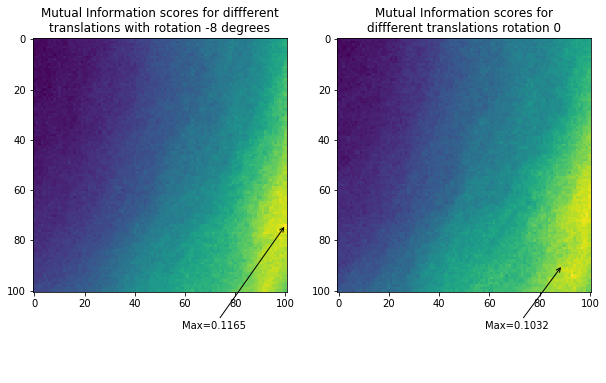

In [82]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(last_region_mi_grid[2,...])
plt.title('Mutual Information scores for diffferent\ntranslations with rotation -8 degrees')
#argmax gives the grid position (0-40 each way) in y,x order. Reverse for plot
mi_loc = list(reversed(np.unravel_index(np.argmax(last_region_mi_grid[2]), last_region_mi_grid[2].shape)))
plt.annotate('Max=%.4f'%np.max(last_region_mi_grid[2]), xy=mi_loc, xycoords='data',
             xytext=(0.3, 0.14), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
plt.subplot(122)
plt.imshow(last_region_mi_grid[6,...])
plt.title('Mutual Information scores for\ndiffferent translations rotation 0')
ami_loc = list(reversed(np.unravel_index(np.argmax(last_region_mi_grid[10]), last_region_mi_grid[10].shape)))
plt.annotate('Max=%.4f'%np.max(last_region_mi_grid[10]), xy=ami_loc, xycoords='data',
             xytext=(0.8, 0.14), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
plt.show()

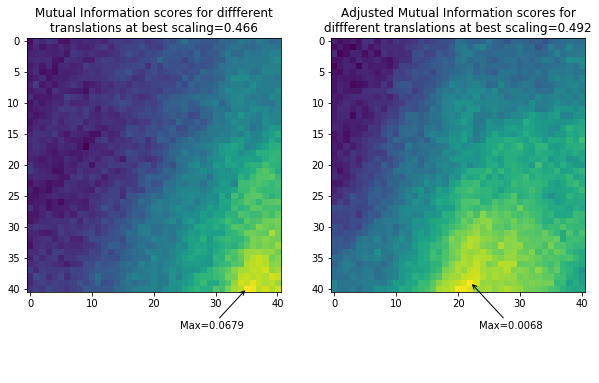

In [136]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(last_region_mi_grid[10,...])
plt.title('Mutual Information scores for diffferent\ntranslations at best scaling=%.3f'%mi_max_at[0])
#argmax gives the grid position (0-40 each way) in y,x order. Reverse for plot
mi_loc = list(reversed(np.unravel_index(np.argmax(last_region_mi_grid[10]), last_region_mi_grid[10].shape)))
plt.annotate('Max=%.4f'%np.max(last_region_mi_grid[10]), xy=mi_loc, xycoords='data',
             xytext=(0.3, 0.14), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
plt.subplot(122)
plt.imshow(last_region_ami_grid[14,...])
plt.title('Adjusted Mutual Information scores for\ndiffferent translations at best scaling=%.3f'%ami_max_at[0])
ami_loc = list(reversed(np.unravel_index(np.argmax(last_region_ami_grid[14]), last_region_ami_grid[14].shape)))
plt.annotate('Max=%.4f'%np.max(last_region_ami_grid[14]), xy=ami_loc, xycoords='data',
             xytext=(0.8, 0.14), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
plt.show()

In [88]:
backup_results = proposed_gt_positions.copy()

In [84]:
np.savetxt('proposed_gt_rot.csv', proposed_gt_positions, delimiter=',')

In [85]:
total_translation=[abs(proposed_gt_positions[i][2]-proposed_gt_positions[i][8]) \
                   + abs(proposed_gt_positions[i][3]-proposed_gt_positions[i][9])
                       for i in range(len(proposed_gt_positions))]

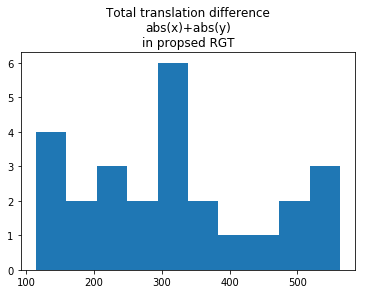

In [86]:
plt.hist(total_translation)
plt.title('Total translation difference\nabs(x)+abs(y)\nin propsed RGT')
plt.show()

In [67]:
'''
Calculate how much the proposed ground truth differs from the given ground truth in translation in 
one given dimension, adjusted for the centre of the image
'''
def adjusted_transl(proposed_pos, x=True):
    offset = int(not x)
    transl = proposed_pos[2+offset]-proposed_pos[8+offset]
    adj = 0.5*(proposed_pos[6+offset]-proposed_pos[12+offset])
    return abs(transl+adj)

'''
Find the euclidean distance between the centre of the GGT and the centre of the proposed RGT
'''
def euclidean_transl(p):
    return np.sqrt(np.square(adjusted_transl(p)) + np.square(adjusted_transl(p, x=False)))

In [73]:
adj_translation = [euclidean_transl(proposed_gt_positions[i]) for i in range(len(proposed_gt_positions))]

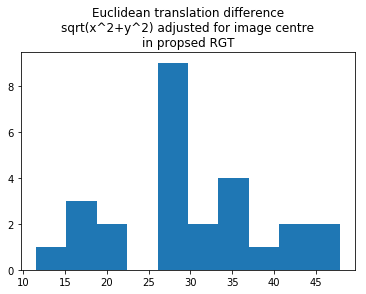

In [75]:
plt.hist(adj_translation)
plt.title('Euclidean translation difference\nsqrt(x^2+y^2) adjusted for image centre\nin propsed RGT')
plt.show()

In [93]:
proposed_gt_names = ('Slide', 'Region', 'GGT_xfrom', 'GGT_yfrom', 'GGT_xto', 'GGT_yto', 'GGT_width', 'GGT_height',\
                     'RGT_xfrom', 'RGT_yfrom', 'RGT_xto', 'RGT_yto', 'RGT_width', 'RGT_height')
', '.join(['%d'%i for i in proposed_gt_positions[25]])

'148185, 20, 6225, 1071, 6468, 1298, 244, 228, 6015, 1174, 6220, 1379, 206, 206'

In [90]:
#Check how many results are boundary cases - where max MI found is at one extreme of the translation grid
max_transl = [max(abs(proposed_gt_positions[i][2]-proposed_gt_positions[i][8]),\
     abs(proposed_gt_positions[i][3]-proposed_gt_positions[i][9])) \
     for i in range(len(proposed_gt_positions))]
bound = [m==20 for m in max_transl]
print('Best translation at boundary in %d out of %d regions (%.1f%%)'%(sum(bound), len(max_transl), 100*sum(bound)/len(max_transl)))
print('Biggest translations:', ','.join(map(str, max_transl)))

Best translation at boundary in 0 out of 26 regions (0.0%)
Biggest translations: 213.0,161.0,185.0,140.0,285.0,151.0,258.0,119.0,105.0,204.0,228.0,219,114.0,112.0,189.0,191.0,268.0,249.0,289,199.0,201.0,153.0,270.0,119,265.0,210.0


Best so far for last image (148185_20), starting from GGT position =(42, 45), allowing 50 pixels either way and fixing scaling at 2.5 (=512/np.mean(gt_positions[:,6:8]))
- New max found at translation (91.000, 91.000)
- Ranges: (91, 91, 207, 232) (0, 0, 205, 205)
- Overlap pixels: (205, 205)
- MI: 0.0788 	AMI: 0.0060

Best so far for last image (148185_20), starting from GGT position =(42,45), allowing 50 pixels either way and scaling between min(ggt_scaling/1.1), max(ggt_scaling\*1.1)
- New max found at translation (49.000, 81.000) and scale 0.487
- Ranges: (49, 81, 249, 242) (0, 0, 249, 249)
- Overlap pixels: (249, 242)
- MI: 0.0723 	AMI: 0.0077

In [ ]:
def gradDescentMIRegister(ref, flo):
    plt.imshow(ref, cmap='gray', vmin=0, vmax=255)
    plt.title("Reference image")
    plt.show()
    plt.imshow(flo, cmap='gray', vmin=0, vmax=255)
    plt.title("Floating image")
    plt.show()

    flo2 = Image.fromarray(flo, mode='L') #Make a copy rather than affecting the passed in data, also convert to an Image
    
    
    init_scaling = np.array([len(ref)/len(flo), len(ref[0])/len(flo[0])]) #initialise scaling by assuming whole region is covered
    init_transl = [0, 0] #initialise translation as zero
    init_params = np.append(init_scaling, init_transl)
    
    #Set up boundaries for parameters
    max_scaling = max(init_scaling * 1.1) #The MPM region shouldn't be much (any) bigger than the cut-out
    min_scaling = min(init_scaling / 1.5)
    max_transl = [ref.shape[0]//3, ref.shape[1]//3]
    min_transl = [-10, -10] # negative translation truncates the floating image but we expect it to be wholly contained within the reference image so keep this small
    
    
    
def getOverlapRegion(flo, ref, trans):
    '''
    Apply transform of trans=[scale, xtransl, ytransl] to floating image flo 
    and return the parts of flo and ref that overlap
    '''
    newsize = np.rint((trans[0] * len(flo), trans[0] * len(flo[0]))).astype(int)
    rescaled_flo = flo2.resize(newsize)
    rescaled_flo = np.asarray(rescaled_flo)

    if trans[1] > 0 and trans[2] > 0:
        ref_range = (trans[1], trans[2], ref.shape[0]-trans[1], ref.shape[1]-trans[2])
        flo_range = (0, 0, rescaled_flo.shape[0], rescaled_flo.shape[1])
    elif trans[1] > 0:
        ref_range = (trans[1], 0, ref.shape[0]-trans[1], ref.shape[1])
        flo_range = (0, -trans[2], rescaled_flo.shape[0], rescaled_flo.shape[1]+trans[2])
    elif trans[2] > 0:
        ref_range = (0, trans[2], ref.shape[0], ref.shape[1]-trans[2])
        flo_range = (-trans[1], 0, rescaled_flo.shape[0]+trans[1], rescaled_flo.shape[1])
    else:
        ref_range = (0, 0, ref.shape[0], ref.shape[1])
        flo_range = (-trans[1], -trans[2], rescaled_flo.shape[0]+trans[1], rescaled_flo.shape[1]+trans[2])

    overlap = (min(ref_range[2], flo_range[2]), min(ref_range[3], flo_range[3]))
    
    return ref[ref_range[0]:(overlap[0]+ref_range[0]), ref_range[1]:(overlap[1]+ref_range[1])], \
            rescaled_flo[flo_range[0]:(overlap[0]+flo_range[0]), flo_range[1]:(overlap[1]+flo_range[1])]



def mi_fun(flo, ref, trans):
    ref_overlap, flo_overlap = getOverlapRegion(flo, trans, ref)
#     mi = mutual_info_score(ref_overlap.flatten(), \
#                            flo_overlap.flatten())
    ami = adjusted_mutual_info_score(ref_overlap.flatten(), \
                           flo_overlap.flatten())
#   print("Translation %r: AMI score is: %.4f"%(trans, ami))
#     if mi > max_mi or ami > max_ami:
#         if mi > max_mi:
#             max_mi = mi
#             mi_max_at = (x, y, xt, yt)
#         if ami > max_ami:
#             max_ami = ami
#             ami_max_at = (x, y, xt, yt)
#         print("New max found at scale (%.3f, %.3f) and translation (%.3f, %.3f)"%(x, y, xt, yt))
#         print('Ranges:', ref_range, flo_range)
#         print('Overlap pixels:',overlap)
#         print('MI: %.4f \tAMI: %.4f'%(mi, ami))
#         plt.imshow(ref[ref_range[0]:(overlap[0]+ref_range[0]), ref_range[1]:(overlap[1]+ref_range[1])], cmap='gray', vmin=0, vmax=255)
#         plt.show()
#         plt.imshow(rescaled_flo[flo_range[0]:(overlap[0]+flo_range[0]), flo_range[1]:(overlap[1]+flo_range[1])], cmap='gray', vmin=0, vmax=255)
#         plt.show()
        
    return ami
    
    
mi_scores, mi_max_at, ami_scores, ami_max_at = gradDescentMIRegister(ref_im, flo_im)

In [ ]:
cutout_locations

In [ ]:
gt_positions

Convert the ground truth data into what we would expect to get as outcome from maximising the MI, i.e. the location  and scale of the MPM region within the cut-out image

The location is the difference between the top left coordinates of the ground truth (gt_positions) and the top left of the cut-out region (which should always be further up and left than the gt position since the cut-out region was chosen to fully include the roi).

The scale is the ratio of the marked roi (gt) to the size of the MPM images which is always 512 square.

In [ ]:
gt_dict = {str(g[0])+'_'+str(g[1]):g[2:] for g in gt_positions}
cutout_dict = {str(c[0])+'_'+str(c[1]):c[2:] for c in cutout_locations}

In [ ]:
gt={}
for key in gt_dict.keys():
    if key in cutout_dict:
        gt[key] = np.append(gt_dict[key][:2] - cutout_dict[key][:2], gt_dict[key][-2:]/512.)

In [ ]:
gt